In [1]:
%matplotlib inline

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from shapely.geometry import Polygon
from skimage import io, exposure
import rasterio
import rasterio.tools.mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, RESAMPLING

In [3]:
cd ~/Downloads/LC80140322013079LGN03/

/Users/Gioia/Downloads/LC80140322013079LGN03


In [64]:
src = rasterio.open('B10.TIF')

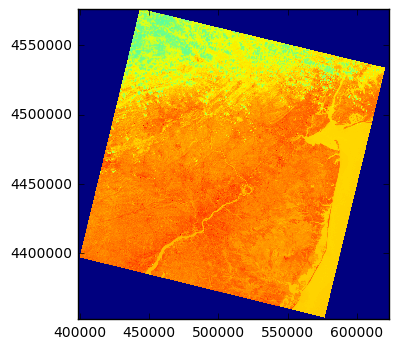

In [5]:
show((src,1))

[Notes](https://mapbox.github.io/rasterio/topics/reproject.html)

### Reproject

In [65]:
dst_crs = 'EPSG:4326'

In [66]:
affine, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)

kwargs = src.meta.copy()
kwargs.update({
    'crs': dst_crs,
    'transform': affine,
    'affine': affine,
    'width': width,
    'height': height
})

In [67]:
tmp = './tmp-5.tiff'

In [68]:
dst = rasterio.open(tmp, 'w', **kwargs)

In [69]:
reproject(
    source=rasterio.band(src, 1),
    destination=rasterio.band(dst, 1),
    src_transform=src.affine,
    src_crs=src.crs,
    dst_transform=affine,
    dst_crs='EPSG:4326',
    resampling=RESAMPLING.nearest)

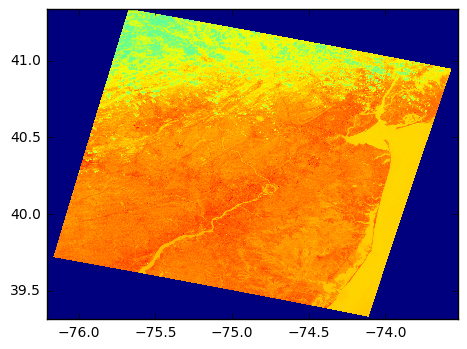

In [70]:
show((dst,1))

In [74]:
src.meta

{'affine': Affine(30.0, 0.0, 398685.0,
       0.0, -30.0, 4575915.0),
 'count': 1,
 'crs': CRS({'init': u'epsg:32618'}),
 'driver': u'GTiff',
 'dtype': 'uint16',
 'height': 7451,
 'nodata': None,
 'transform': (398685.0, 30.0, 0.0, 4575915.0, 0.0, -30.0),
 'width': 7481}

In [78]:
dst.read(1).shape

(6431, 8527)

In [79]:
dst.write(dst.read(1), indexes=1)

In [80]:
dst.close()

In [44]:
rasterio.band(dst,1)

AttributeError: 'numpy.ndarray' object has no attribute 'dtypes'

In [32]:
src.meta

{'affine': Affine(30.0, 0.0, 398685.0,
       0.0, -30.0, 4575915.0),
 'count': 1,
 'crs': CRS({'init': u'epsg:32618'}),
 'driver': u'GTiff',
 'dtype': 'uint16',
 'height': 7451,
 'nodata': None,
 'transform': (398685.0, 30.0, 0.0, 4575915.0, 0.0, -30.0),
 'width': 7481}

In [233]:
dst_crs = 'EPSG:4326'

with rasterio.open('B10.TIF') as src:
    affine, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': affine,
        'affine': affine,
        'width': width,
        'height': height
    })

    with rasterio.open('tmp.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.affine,
                src_crs=src.crs,
                dst_transform=affine,
                dst_crs=dst_crs,
                resampling=RESAMPLING.nearest)

In [236]:
src = rasterio.open('tmp.tif')

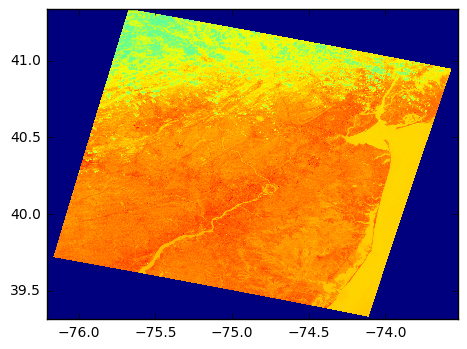

In [238]:
show((src,1))

## Create Areas to become masked and subset

In [239]:
nj = gp.read_file('/Users/Gioia/Projects/landfill-satellites/data/output/Landfill_Sites_in_New_Jersey.shp')

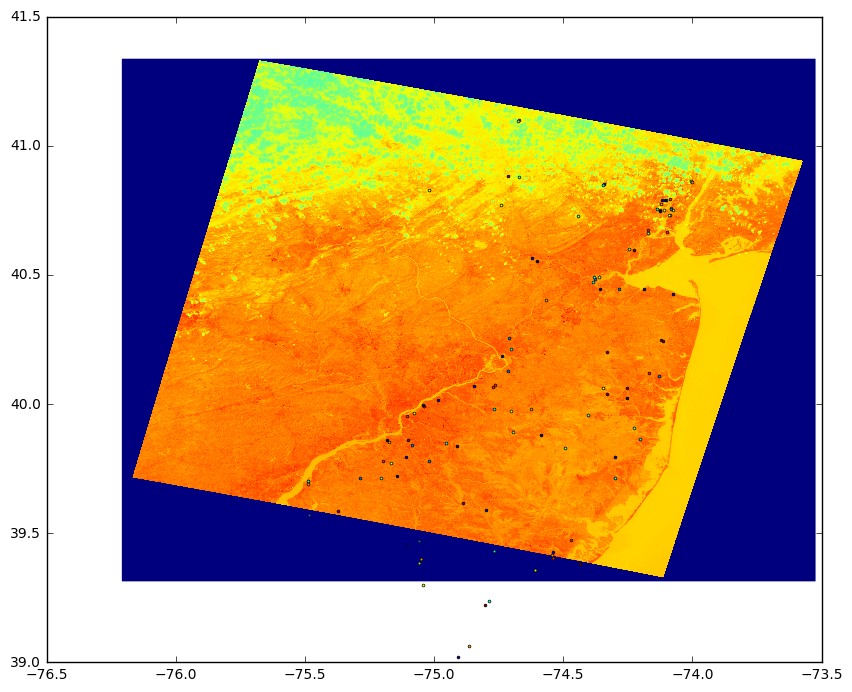

In [240]:
fig, ax = plt.subplots(1, figsize=(10,10))
show((src,1), ax=ax)
nj.plot(ax=ax)
plt.show()

In [241]:
def km_to_deg(km):
    '''
    Parameters
    ----------
    km: float,
        Distance in km to be converted latlng
    '''
    return km * (1./110.574)

In [242]:
def create_buffer(bounds, dist):
    '''
    Parameters
    ----------
    bounds : array,
      Minx, miny, maxx and maxy of geometry
    dist : float,
      Distance to create buffer
    '''
    n_minx = bounds['minx'] - dist
    n_miny = bounds['miny'] - dist
    n_maxx = bounds['maxx'] + dist
    n_maxy = bounds['maxy'] + dist
    
    coords = ((n_minx, n_miny), (n_minx, n_maxy), (n_maxx, n_maxy), (n_maxx, n_miny), (n_minx, n_miny))
    return Polygon(coords)
    

In [243]:
bounds = nj['geometry'].bounds

In [245]:
# increase the size of the bounds by 10 km
d = km_to_deg(5)
geom = bounds.apply(create_buffer, axis=1, args=(d,))

In [246]:
nj['geometry'] = geom

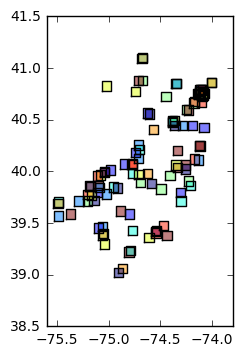

In [247]:
nj.plot()

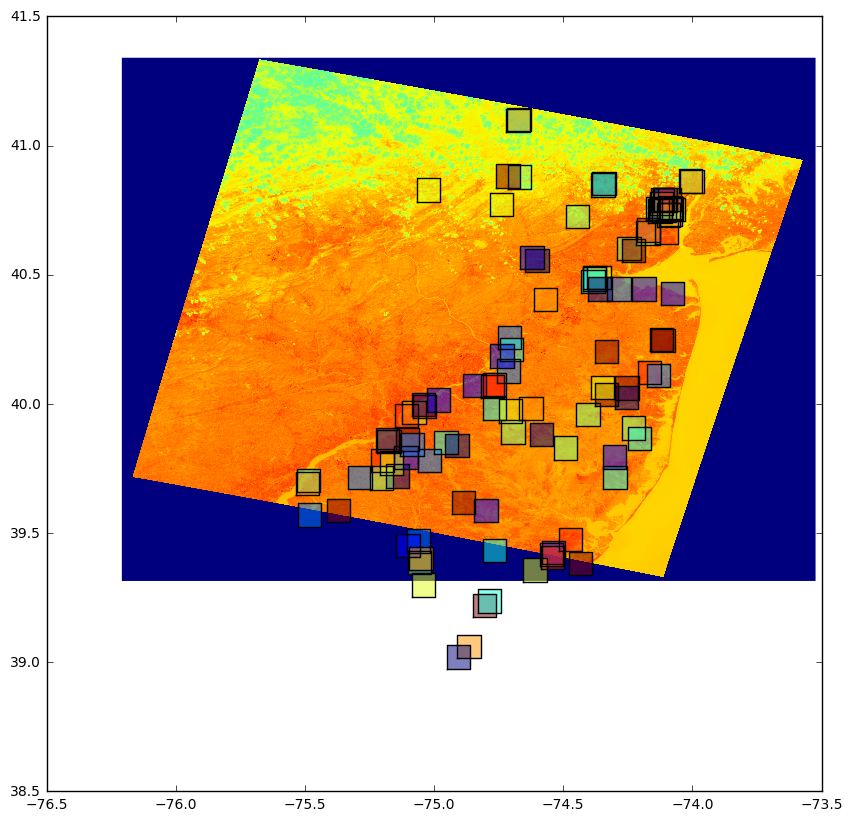

In [248]:
fig, ax = plt.subplots(1, figsize=(10,10))
show((src,1), ax=ax)
nj.plot(ax=ax)
plt.show()

## Apply Mask

In [249]:
# export just the first mask - not sure of a better way to do this
fname = '/Users/Gioia/Projects/landfill-satellites/data/output/poly.shp'
boundary = nj[:1]['geometry']
boundary.to_file(fname)

In [252]:
with fiona.open(fw, "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

In [253]:
out_image, out_transform = rasterio.tools.mask.mask(src, features, crop=True)

out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})    

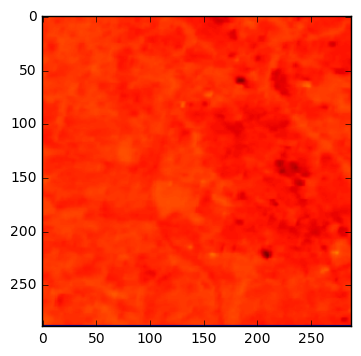

In [256]:
show((out_image))